# Stat222 HW3

Seokjun Choi

*All code blocks are Python scripts.*
*Used Python version is 3.10.5 for Windows, 64 bits.*

## Question 3

*Python script:*
- Q3: https://github.com/letsjdosth/bnp/blob/main/hw3_q3.py
- dependencies
    - latest versions of `numpy`, `scipy`, `matplotlib` for python 3 
    - ./hwk3-data.txt

Following the model in the question, I implement the Mean-Field Variational Bayes algorithm.
Since this model is the same as the model in the lecture note, I skip all details and will just attach the code.
I will use the lecture note's notation.

I fix some parameters instead of putting a hyperprior.
The question directed me to use the *optimal* value based on Q1's result, but I didn't use them.
Calculating mode based on posterior samples requires binning, so the model value is highly affected by the binning grid, which is unpleasant.
Instead, I use the mean-value $m=-0.06$ and $s^2=16.45$ of the Q1 fit. For $\alpha$, I use $0.6$ based on its mean value in Q1.
However, I admit that it is not a very good idea to use mean values as tunning parameter values for a mode-finding algorithm.

Several simulations show that the hyperparameters for $\phi$'s distribution $a_\phi, b_\phi$ are very important to yield a proper posterior density curve.
If we set too vague and heavy-tailed prior for $\phi$ with too small $s^2$, the posterior tends to have just one normal component with $N=1$, losing the ability to catch three modes with very huge posterior $\phi|y$. That's why I introduce an informative prior for $\phi$ here. I set $\phi \sim \text{gamma}(100, 100)$, very strongly supporting $\phi=1$.

The class `Hw3Q1_MeanfieldVB` is my implementation.

In [31]:
from math import exp, log
import time
from random import gammavariate

import numpy as np
import scipy.stats as sp_stats
from scipy.special import digamma
import matplotlib.pyplot as plt

class Hw3Q1_MeanfieldVB:
    def __init__(self, initial, y_obs: list, truncation_N:int) -> None:
        
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]

        self.initial = initial
        self.optim_path = [initial]
        self.y = y_obs
        self.n = len(y_obs)

        # truncation
        self.truncation_N = truncation_N
        
        # fixed parameters
        self.hyper_m = -0.06
        self.hyper_s2 = 16.45
        self.hyper_alpha = 0.6

        self.hyper_a_phi = 100
        self.hyper_b_phi = 100

        

    def deep_copier(self, x_iterable) -> list:
        rep_x_list = []
        for x in x_iterable:
            try:
                _ = iter(x)
                rep_x_list.append(self.deep_copier(x))
            except TypeError:
                rep_x_list.append(x)
        return rep_x_list

    def one_iter_optimizer(self):
        new = self.deep_copier(self.optim_path[-1])
        # update iteratively
        new = self._update_param_gamma(new)
        new = self._update_param_xi(new)
        new = self._update_param_pi(new)
        new = self._update_param_beta(new)
        self.optim_path.append(new)

    def _pi_sum_over_n(self, pi_mat: list[list[float]]):
        #pi_mat : n by N
        np_pi_mat = np.array(pi_mat, dtype="float32")
        col_sum = np.sum(np_pi_mat, axis=0) #column sum
        return col_sum.tolist()

    def _update_param_gamma(self, last_param):
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]

        new_gamma = []
        pi_col_sum = self._pi_sum_over_n(last_param[4])
        for l in range(self.truncation_N-1):
            new_gamma_l = [1 + pi_col_sum[l], self.hyper_alpha + sum(pi_col_sum[l+1:])]
            new_gamma.append(new_gamma_l)

        new_param = last_param #pointer
        new_param[2] = new_gamma
        return new_param
    
    def _update_param_xi(self, last_param):
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]

        new_xi = []
        pi_col_sum = self._pi_sum_over_n(last_param[4])
        b1b2inv = last_param[0]/last_param[1]
        for l in range(self.truncation_N):
            sum_y_i_pi_il = 0
            for y_i, pi_i in zip(self.y, last_param[4]):
                sum_y_i_pi_il += (y_i * pi_i[l])
            
            new_xi_l1 = (self.hyper_m+self.hyper_s2*b1b2inv*sum_y_i_pi_il)/(1+self.hyper_s2*b1b2inv*pi_col_sum[l])
            new_xi_l2 = 1/(1/self.hyper_s2 + b1b2inv*pi_col_sum[l])
            new_xi.append([new_xi_l1, new_xi_l2])
        
        new_param = last_param #pointer
        new_param[3] = new_xi
        return new_param


    def _update_param_pi(self, last_param):
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]
        beta1 = last_param[0]
        beta2 = last_param[1]

        new_pi = []
        gamma_until_lminus1_sum_vec = [0]
        for gamma_l1, gamma_l2 in last_param[2]:
            cum_sum = gamma_until_lminus1_sum_vec[-1] + digamma(gamma_l2) - digamma(gamma_l1+gamma_l2)
            gamma_until_lminus1_sum_vec.append(cum_sum)

        for y_i in self.y:
            W_i_vec = []
            for l, (xi_l1, xi_l2) in enumerate(last_param[3]):
                W_il = 0.5*(digamma(beta1)-log(beta2))
                W_il -= (0.5*beta1/beta2 * (y_i**2 - 2*y_i*xi_l1 + xi_l2 + xi_l1**2))
                if l < self.truncation_N-1:
                    gamma_l1 = last_param[2][l][0]
                    gamma_l2 = last_param[2][l][1]
                    W_il += (digamma(gamma_l1) - digamma(gamma_l1+gamma_l2))
                W_il += gamma_until_lminus1_sum_vec[l]
                W_i_vec.append(W_il)
            unnormalized_e_Wi = [exp(w) for w in W_i_vec]
            nomalizing_const = sum(unnormalized_e_Wi)
            new_pi_i = [w/nomalizing_const for w in unnormalized_e_Wi]
            new_pi.append(new_pi_i)
        
        new_param = last_param #pointer
        new_param[4] = new_pi
        return new_param

    def _update_param_beta(self, last_param):
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]
        
        new_beta1 = self.hyper_a_phi + self.n/2
        new_beta2 = self.hyper_b_phi
        for pi_i, y_i in zip(last_param[4], self.y):
            for l, xi_l in enumerate(last_param[3]):
                new_beta2 += (0.5*pi_i[l]*(y_i**2 - 2*y_i*xi_l[0] + xi_l[1] + xi_l[0]**2))
        new_param = last_param
        new_param[0] = new_beta1
        new_param[1] = new_beta2
        return new_param

    def _l2_norm(self, v1, v2):
        norm_square = 0
        for s1, s2 in zip(v1, v2):
            try:
                _ = iter(s1)
                norm_square += self._l2_norm(s1, s2)
            except TypeError:
                norm_square += (s1-s2)**2
        return norm_square**0.5

    def run(self, tol, print_iter_cycle=100):
        start_time = time.time()
        i = 0
        while True:
            i += 1
            last = self.optim_path[-1]
            self.one_iter_optimizer()
            new = self.optim_path[-1]

            diff = self._l2_norm(last, new)
            elap_time = time.time()-start_time
            if diff < tol:
                break
            
            if i%print_iter_cycle == 0:
                print("iteration", i, ", l2 norm diff:", diff, ", elapsed time:", elap_time//60,"min ", elap_time%60,"sec")

        print("iteration", i, " done! (elapsed time for execution: ", elap_time//60,"min ", elap_time%60,"sec)")

    def construct_estimate_density(self, grid, MC_integral_num_iter=50):
        #variational parameter
        # 0      1      2                                  3                           4
        #[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]
        optim_pt = self.optim_path[-1]
        p_y_post_vec = []
        for y in grid:
            p_y_post = 0
            # l = 0
            eqplV = optim_pt[2][0][0]/sum(optim_pt[2][0])
            product_1minusV = optim_pt[2][0][1]/sum(optim_pt[2][0])
            phi = gammavariate(optim_pt[0], 1/optim_pt[1])
            eqNy = sp_stats.norm.pdf(y, optim_pt[3][0][0], (optim_pt[3][0][1]+1/phi)**0.5)
            p_y_post += (eqplV*eqNy)

            for l in range(1, self.truncation_N-1):
                gamma_l1, gamma_l2 = optim_pt[2][l]
                eqplV = product_1minusV * gamma_l1/(gamma_l1+gamma_l2)
                product_1minusV *= (gamma_l2/(gamma_l1+gamma_l2))
                eqNy_sum = 0
                for _ in range(MC_integral_num_iter):
                    phi = gammavariate(optim_pt[0], 1/optim_pt[1])
                    eqNy = sp_stats.norm.pdf(y, optim_pt[3][l][0], (optim_pt[3][l][1]+1/phi)**0.5)
                    eqNy_sum += eqNy
                eqNy_mean = eqNy_sum / MC_integral_num_iter
                p_y_post += (eqplV*eqNy_mean)
            
            # l = N
            eqplV = product_1minusV
            eqNy_sum = 0
            for _ in range(MC_integral_num_iter):
                phi = gammavariate(optim_pt[0], 1/optim_pt[1])
                eqNy = sp_stats.norm.pdf(y, optim_pt[3][self.truncation_N-1][0], (optim_pt[3][self.truncation_N-1][1]+1/phi)**0.5)
                eqNy_sum += eqNy
            eqNy_mean = eqNy_sum / MC_integral_num_iter
            p_y_post += (eqplV*eqNy_mean)
            p_y_post_vec.append(p_y_post)
        return p_y_post_vec



Next, let me load the data and fit the posterior mode.
For the stopping rule, I use $l_2$ distance for a parameter vector. 
The algorithm will stop if the current and previous variational parameter vectors have a smaller distance than the pre-specified tolerance level.
I use $0.1$ for the tolerance level.

For the truncation level $N$ (the level of approximation), I set $N=100$.

For the initial value of the variational parameters, I set $\beta_1, \beta_2$ as $1$, and all $\gamma_{l1}=\gamma_{l2}=1$ for all $l$.
For $\xi_{l1}, \xi_{l2}$ that are parameters for normal distribution component, I set $0$ and $10$, respectively, for all $l$.
For $\pi_{ij}$, $i=1,...,n$ and $j=1,...,N$, I use $1/N$ for all.
This setting seems too reckless, especially when we worry about local minima.
But I set very strong prior for $\phi$ and fixed parameters $m, s^2, \alpha$ very close to the actual value; initial values are relatively less important in my context.
However, if we didn't know the good fixed parameter value, we would have taken much care of the initial values.

In [32]:
data = []
with open("data/hwk3-data.txt", "r", newline="\n") as f:
    for line in f:
        data.append(float(line))
print(len(data)) #250

truncation_N = 100
initial = [1, 1,
            [[1,1] for _ in range(truncation_N-1)], 
            [[0,10] for _ in range(truncation_N)],
            [[1/truncation_N for _ in range(truncation_N)] for _ in range(len(data))]]
vb_inst = Hw3Q1_MeanfieldVB(initial, data, truncation_N)
vb_inst.run(tol=0.1)
optim_pt = vb_inst.optim_path[-1]
#variational parameter
# 0      1      2                                  3                           4
#[beta1, beta2, [(gamma_l1,gamma_l2),l=1,...,N-1], [(xi_l1,xi_l2), l=1,...,N], (pi_i1,...,pi_iN),i=1,...,n]

250
iteration 100 , l2 norm diff: 1.8410496016578022 , elapsed time: 0.0 min  13.852308511734009 sec
iteration 200 , l2 norm diff: 1.2382673242634143 , elapsed time: 0.0 min  28.846890926361084 sec
iteration 300 , l2 norm diff: 0.9985535059149045 , elapsed time: 0.0 min  42.770241022109985 sec
iteration 400 , l2 norm diff: 0.8444908880499963 , elapsed time: 0.0 min  56.363483905792236 sec
iteration 500 , l2 norm diff: 2.0715006666777795 , elapsed time: 1.0 min  10.63888931274414 sec
iteration 537  done! (elapsed time for execution:  1.0 min  15.56923246383667 sec)


The 500th iteration shows some weird $l_2$ norm value, but anyway, the algorithm stops at the 537th iteration.
Let's see the optimal point in detail.

To begin with, I show the distribution of $\phi$ and the first five $Z_{L_i}$ for $i=1,2,...,5$ as examples.
(Oh, because Python's list index system starts at 0, the output starts at 0 and ends at 4. but it corresponds to $i=1,...5$.)

In [36]:
# print('optim pt:', optim_pt) # too long to print
print("data(the first 5):", data[0:5])
data_idx_list = [i for i in range(5)]
print("phi|y~ gamma(",optim_pt[0],",", optim_pt[1],")")
for i in data_idx_list:
    Li = None
    temp_pi = 0
    for l, pi_il in enumerate(optim_pt[4][i]):
        if temp_pi < pi_il:
            Li = l
            temp_pi = pi_il
    print("L"+str(i)+"|y = ", Li, " with prob ", temp_pi)
    print("Z_L"+str(i)+"|y~ N(", optim_pt[3][Li][0], ",", optim_pt[3][Li][0], ")")

data(the first 5): [-0.464363, -5.41594, -4.03439, 3.88329, -0.0296465]
phi|y~ gamma( 225.0 , 221.2894303775616 )
L0|y =  2  with prob  0.9995965170919194
Z_L0|y~ N( -0.03975108751712629 , -0.03975108751712629 )
L1|y =  0  with prob  0.9999989717689094
Z_L1|y~ N( -5.04479201434696 , -5.04479201434696 )
L2|y =  0  with prob  0.9988386496543531
Z_L2|y~ N( -5.04479201434696 , -5.04479201434696 )
L3|y =  3  with prob  0.999058276312127
Z_L3|y~ N( 3.3111708671775384 , 3.3111708671775384 )
L4|y =  2  with prob  0.9982796471683525
Z_L4|y~ N( -0.03975108751712629 , -0.03975108751712629 )


The posterior distribution $\phi$ has its mean near 1. Note that the true $\phi$ is 1.

Thanks to the truncated stick-breaking structure, I could straightforwardly get $L_i$, the clustered index, and its probability.
We can also construct the posterior distribution of $Z_{L_I}$ without heavy computational burden.

Next, let me construct the density curve. It requires Monte Carlo integration. 
In the class I defined above, the method `Hw3Q1_MeanfieldVB.construct_estimate_density` does this work.
I repeat 50 iterations to sample from the gamma distribution and evaluate the normal kernel values to approximate $E_q(N(y_0|Z_l,\phi^{-1}))$ for each $l=1,...,N$ and each grid point.
Luckily, this work is quick.

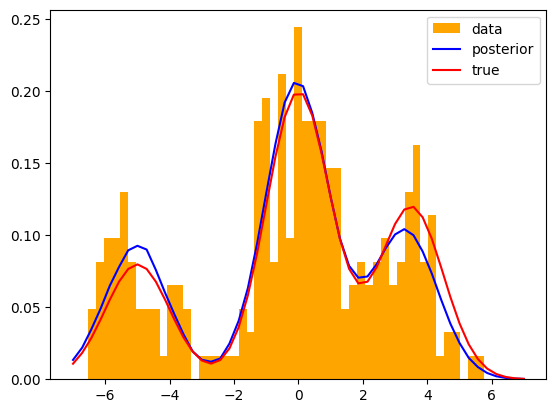

In [34]:
grid = np.linspace(-7, 7, 50).tolist()
density_pt_est_on_grid = vb_inst.construct_estimate_density(grid)
density_true_on_grid = [0.2*sp_stats.norm.pdf(x, -5, 1)+0.5*sp_stats.norm.pdf(x, 0, 1)+0.3*sp_stats.norm.pdf(x, 3.5, 1) for x in grid]


plt.hist(data, bins=50, density=True, color="orange", label='data')
plt.plot(grid, density_pt_est_on_grid, color="blue", label='posterior')
plt.plot(grid, density_true_on_grid, color="red", label='true')
plt.legend()
plt.show()

The posterior density function approximated by MFVB (the blue curve) looks nice!
It is close to the density function (the red curve), even if it loses some mass near the third mode.